## Library Packages

In [25]:
!pip install split-folders
!pip install transformers

In [59]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import shutil
import splitfolders
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

## Setting Configuration and Functions

In [3]:
# paths
SOURCE_DIR = "/kaggle/input/image-classification"
WORKING_DIR = "/kaggle/working/dataset"

# source path
TRAIN_SRC = os.path.join(SOURCE_DIR, "images", "images")  
VALID_SRC = os.path.join(SOURCE_DIR, "validation", "validation")
TEST_SRC = os.path.join(SOURCE_DIR, "test", "test")

# dataset path
TRAIN_DIR = os.path.join(WORKING_DIR, "train")  
VALID_DIR = os.path.join(WORKING_DIR, "val")
TEST_DIR = os.path.join(WORKING_DIR, "test")

In [4]:
# count images per class
def count_images_in_folder(folder):
    class_counts = {}
    for class_name in sorted(os.listdir(folder)):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

In [5]:
# plot class count
def plot_class_counts_split(train_counts, val_counts, test_counts=None):
    # jumlah plot
    include_test = test_counts and len(test_counts) > 0
    num_plots = 3 if include_test else 2

    # subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))

    if num_plots == 2:
        ax1, ax2 = axes
    else:
        ax1, ax2, ax3 = axes

    # train plot
    train_classes = list(train_counts.keys())
    train_values = [train_counts[c] for c in train_classes]
    ax1.bar(train_classes, train_values, color='skyblue')
    ax1.set_title('Train Dataset')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Image Counts')
    ax1.tick_params(axis='x', rotation=45)

    # validation plot
    val_classes = list(val_counts.keys())
    val_values = [val_counts[c] for c in val_classes]
    ax2.bar(val_classes, val_values, color='orange')
    ax2.set_title('Validation Dataset')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Image Counts')
    ax2.tick_params(axis='x', rotation=45)

    # test plot
    if include_test:
        test_classes = list(test_counts.keys())
        test_values = [test_counts[c] for c in test_classes]
        ax3.bar(test_classes, test_values, color='green')
        ax3.set_title('Test Dataset')
        ax3.set_xlabel('Classes')
        ax3.set_ylabel('Image Counts')
        ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_history(hist):
    acc = hist.history['accuracy'] 
    val_acc = hist.history['val_accuracy'] 
    loss = hist.history['loss'] 
    val_loss = hist.history['val_loss'] 
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## EDA - Data Count

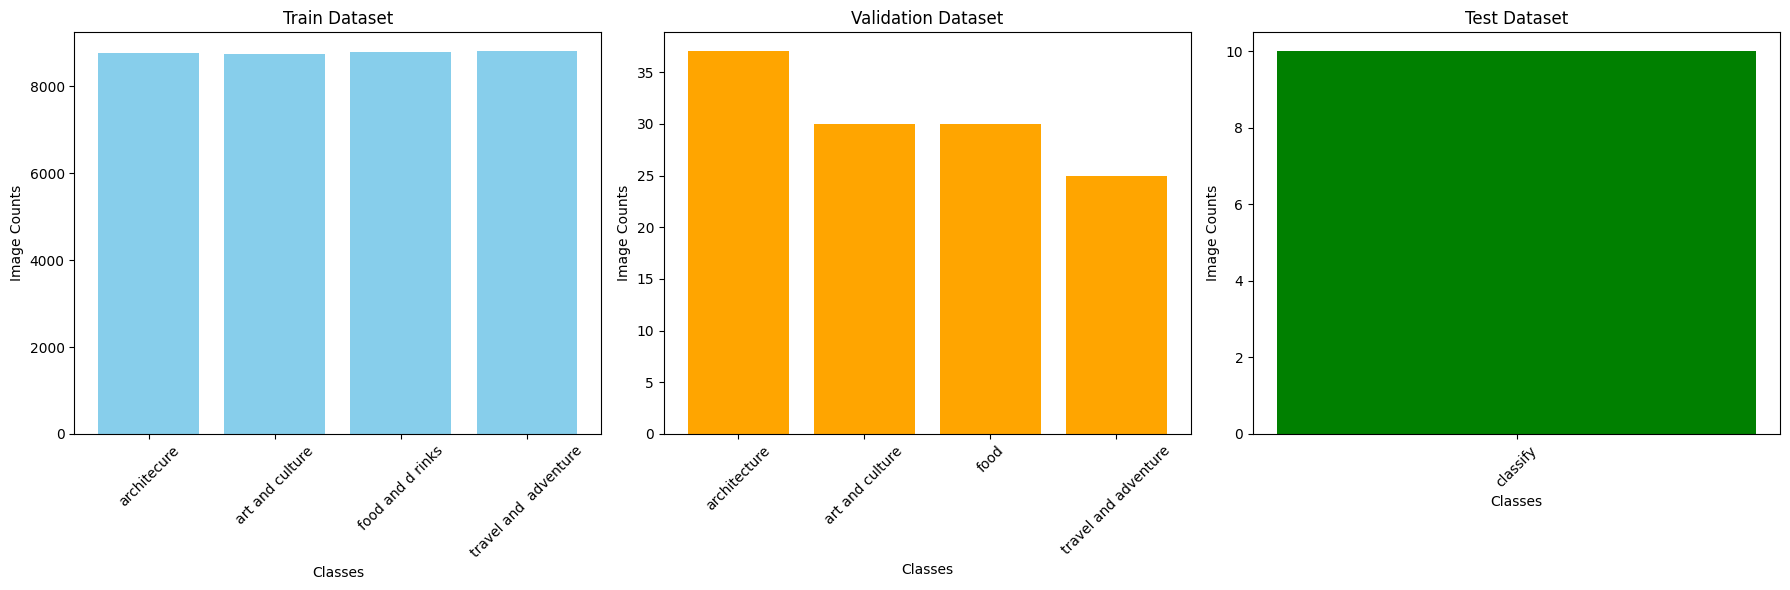

In [6]:
# Count per dataset
train_counts = count_images_in_folder(TRAIN_SRC)
val_counts = count_images_in_folder(VALID_SRC)
test_counts = count_images_in_folder(TEST_SRC)

# Visualize the class counts with 3 separate plots for Train, Validation, and Test
plot_class_counts_split(train_counts, val_counts, test_counts)

## Data Splitting

In [7]:
# split "images" to "train" and "validation"
splitfolders.ratio(
    TRAIN_SRC,
    output=WORKING_DIR,
    seed=42,
    ratio=(.8, .2)
)

Copying files: 35095 files [06:12, 94.24 files/s] 


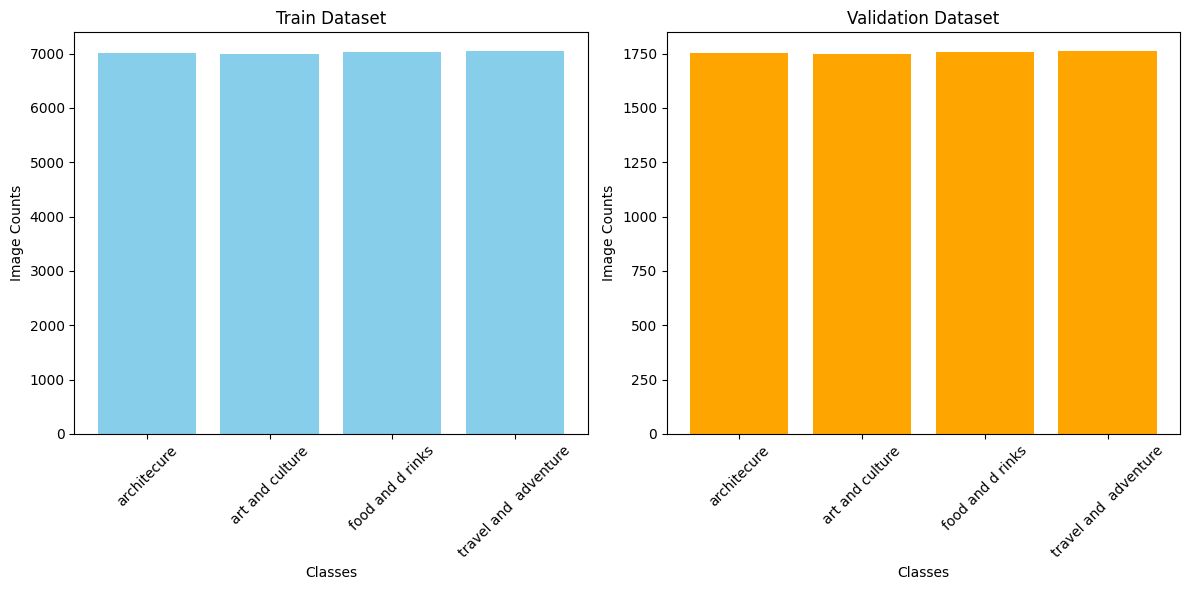

In [9]:
# count per dataset
train_counts = count_images_in_folder(TRAIN_DIR)
val_counts = count_images_in_folder(VALID_DIR)

# visualize count
plot_class_counts_split(train_counts, val_counts)

## Preprocessing

In [10]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 4

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    VALID_SRC,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 28073 images belonging to 4 classes.
Found 7020 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


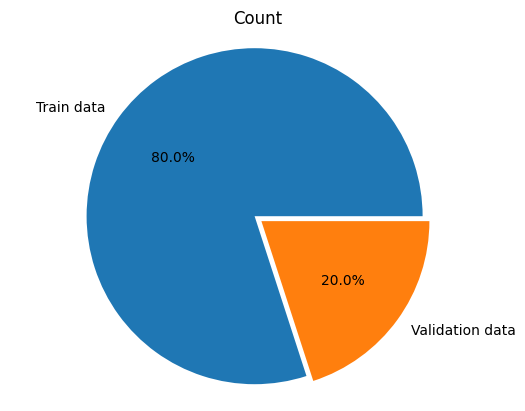

In [12]:
# visualize the proportion of training and validation data
labels = ['Train data', 'Validation data']
values = [len(train_generator.filenames), len(validation_generator.filenames)]
plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=False, explode=(0, 0.05))
plt.axis('equal')
plt.title('Count')
plt.show()

## Modeling

### Initial Training

In [ ]:
# define base model using VGG16
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Setup EarlyStopping to monitor validation accuracy and stop if no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          
    restore_best_weights=True
)

# Train
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
 58/878 ━━━━━━━━━━━━━━━━━━━━ 5:03 371ms/step - accuracy: 0.5633 - loss: 1.0270

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


160/878 ━━━━━━━━━━━━━━━━━━━━ 4:25 369ms/step - accuracy: 0.6567 - loss: 0.8498

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


878/878 ━━━━━━━━━━━━━━━━━━━━ 400s 434ms/step - accuracy: 0.7658 - loss: 0.6135 - val_accuracy: 0.8704 - val_loss: 0.3560
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 369s 417ms/step - accuracy: 0.8555 - loss: 0.3920 - val_accuracy: 0.8812 - val_loss: 0.3272
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 370s 419ms/step - accuracy: 0.8703 - loss: 0.3485 - val_accuracy: 0.8849 - val_loss: 0.3228
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 387s 438ms/step - accuracy: 0.8801 - loss: 0.3186 - val_accuracy: 0.8744 - val_loss: 0.3473
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 375s 424ms/step - accuracy: 0.8873 - loss: 0.3079 - val_accuracy: 0.8899 - val_loss: 0.3019
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 375s 424ms/step - accuracy: 0.8909 - loss: 0.2993 - val_accuracy: 0.8972 - val_loss: 0.2937
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 378s 427ms/step - accuracy: 0.9007 - loss: 0.2740 - val_accuracy: 0.8781 - val_loss: 0.3509
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 390s 441ms/step - accuracy: 0.9030 - loss: 0.26

In [62]:
model.save("/kaggle/working/model/best_model.h5")

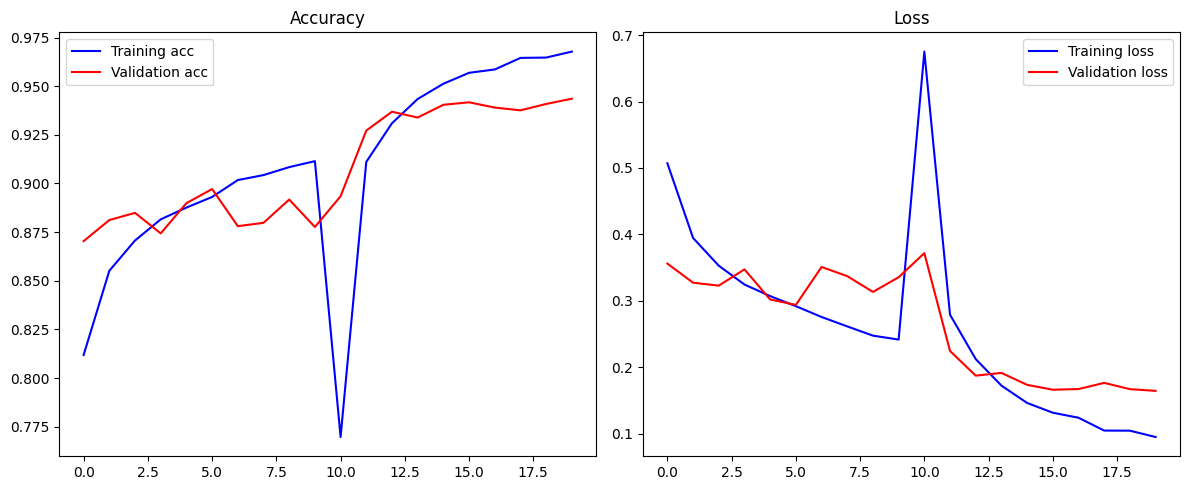

In [63]:
plot_history(history)

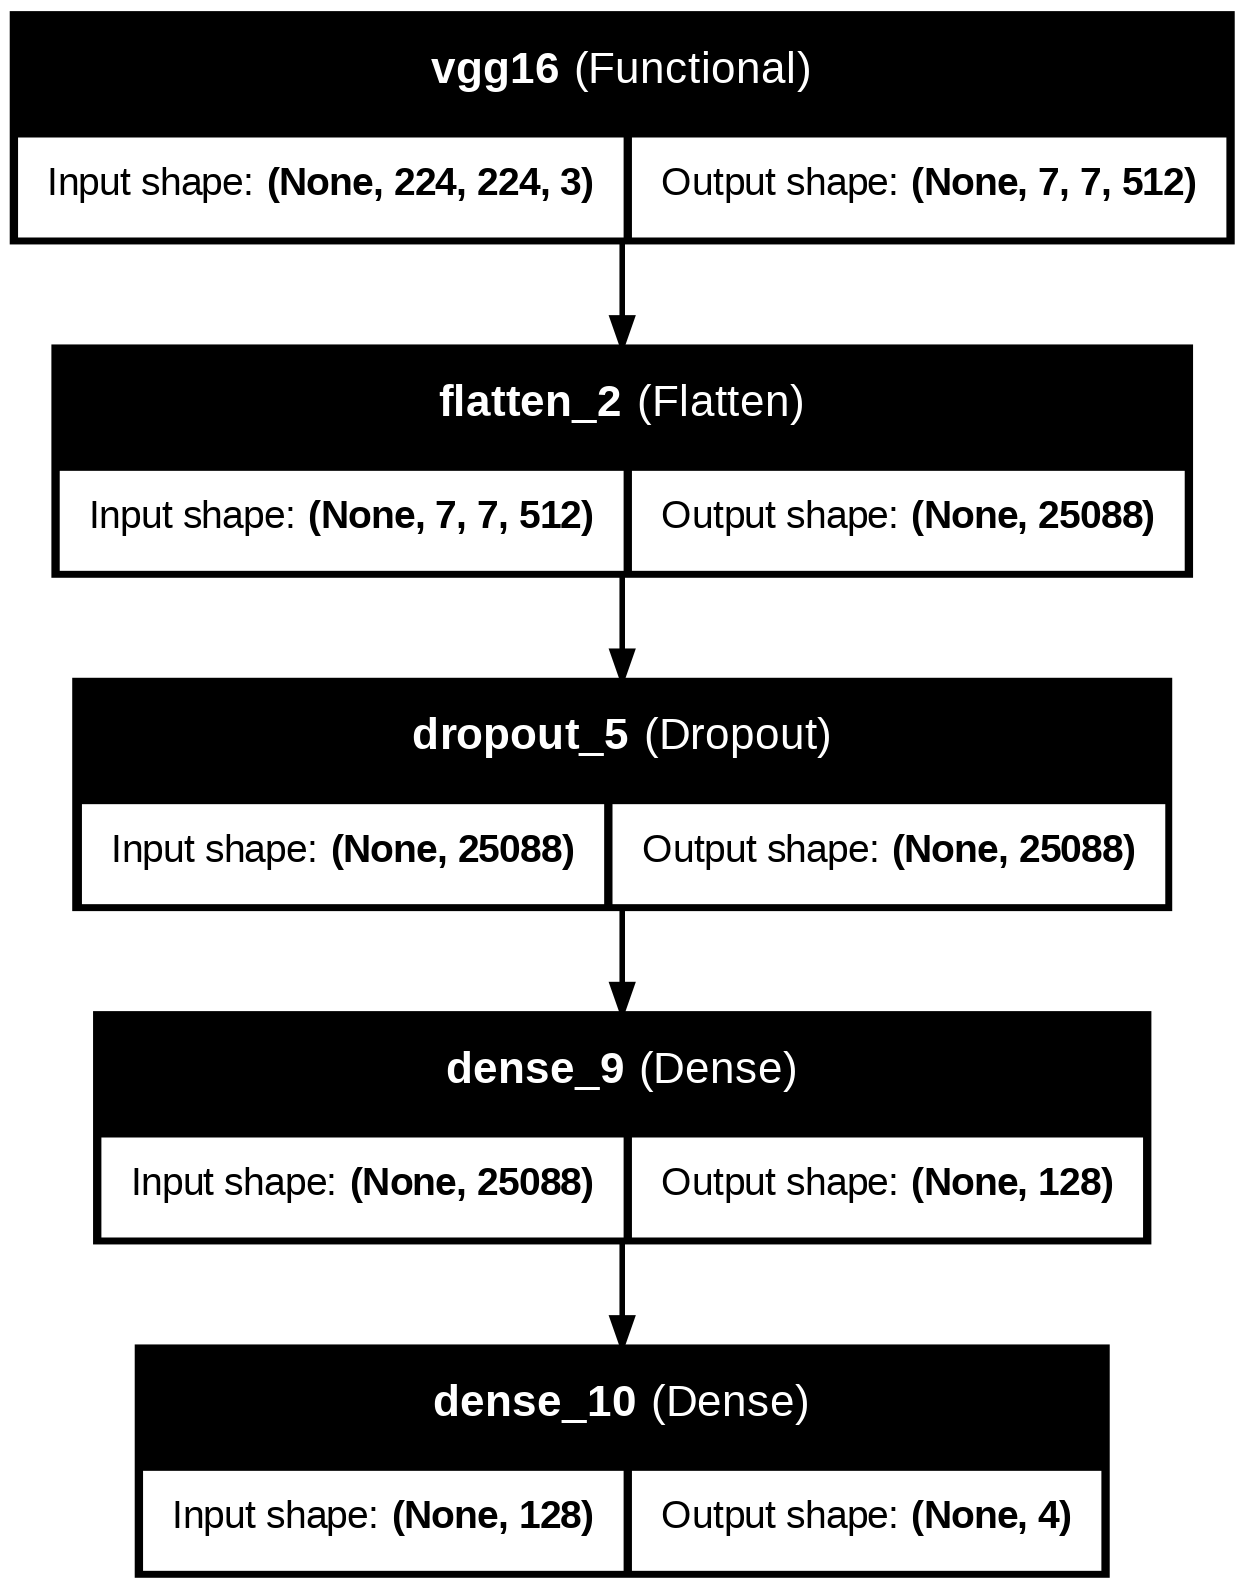

In [64]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot model dan simpan ke file PNG
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Tampilkan di notebook
# Image(retina=True, filename='model_plot.png')

## Evaluation

In [65]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9771 - loss: 0.1148
Test Accuracy: 0.9426


122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


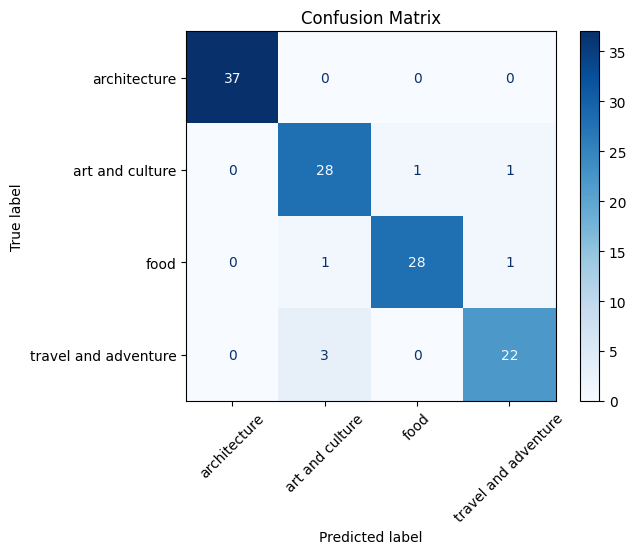

In [66]:
# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=1)

# Ambil prediksi kelas (index dengan probabilitas tertinggi)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
labels = list(test_generator.class_indices.keys())  # Kelas dari directory

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
